In [2]:
from citros_data_analysis import data_access as da

# System with spring

Let's create CitrosDB obkect to query and plot the results of the simulation. Let's specify that we would like to see batches that were created with system with spring simulation scenario:

In [3]:
citros = da.CitrosDB(simulation = 'simulation_system_with_spring')

In [4]:
citros.search_batch()

{'cloud_test_system_with_spring_1': {'id': '24c1988a-e6d9-4270-a776-a90554102ea7',
  'sid': [0],
  'created_at': '2023-11-26T08:37:36.041625+00:00',
  'updated_at': '2023-11-26T08:39:47.74387+00:00',
  'status': 'DONE',
  'data_status': 'LOADED',
  'data_last_access': '2023-11-26T08:37:36.041625+00:00',
  'tag': 'afbb2ce8450c715fff4d694bfe2967541c7031e8',
  'simulation': 'simulation_system_with_spring',
  'message': 'new_data_structure',
  'parallelism': 1,
  'completions': 1,
  'cpu': 2,
  'gpu': 0,
  'memory': '265',
  'repo': 'pendulum',
  'link': 'https://citros.io/pendulum/data/runs/simulation_system_with_spring/cloud_test_system_with_spring_1'},
 'cloud_test_system_with_spring': {'id': '12dc2316-d71b-40ae-83d8-69c7b5f0f717',
  'sid': [0],
  'created_at': '2023-11-22T13:48:05.716389+00:00',
  'updated_at': '2023-11-26T14:00:00.008791+00:00',
  'status': 'DONE',
  'data_status': 'UNLOADED',
  'data_last_access': '2023-11-22T15:05:17.055811+00:00',
  'tag': 'f5cb8e822b32677232cbc398

Let's print the names of the batches containing simulations with the status 'DONE'. This indicates that the simulations have successfully finished:

In [5]:
list(citros.search_batch(sid_status='DONE').keys())

['cloud_test_system_with_spring_1', 'cloud_test_system_with_spring']

Print general information about the most recent simulation. In this simulation we have two topics: '/config' and '/coordinates':

In [6]:
citros.batch(-1).info().print()

{
 'size': '792 kB',
 'sid_count': 1,
 'sid_list': [0],
 'topic_count': 2,
 'topic_list': ['/config', '/coordinates'],
 'message_count': 1003
}


Topic '/config' contains initial parameters of the simulation, topic '/coordinates' contains result of the simulation. Let's look on data structure of the topic '/coordinates':

In [7]:
citros.batch(-1).topic('/coordinates').info().print()

{
 'size': '791 kB',
 'sid_count': 1,
 'sid_list': [0],
 'topic_count': 1,
 'topic_list': ['/coordinates'],
 'message_count': 1001,
 'topics': {
   '/coordinates': {
     'type': 'system_with_spring_interfaces/msg/SpringSystem',
     'data_structure': {
       'data': {
         't': 'float',
         'p1': {
           'x': 'float',
           'y': 'float',
           '__msgtype__': 'str'
         },
         'p2': {
           'x': 'float',
           'y': 'float',
           '__msgtype__': 'str'
         },
         'p3': {
           'x': 'float',
           'y': 'float',
           '__msgtype__': 'str'
         },
         'spr': {
           'x0': 'float',
           'x1': 'float',
           'y0': 'float',
           'y1': 'float',
           '__msgtype__': 'str'
         },
         '__msgtype__': 'str'
       }
     },
     'message_count': 1001
   }
 }
}


As we stated in the README, the result of the simulation has the following structure: there is time coordinate 'data.t', two coordinates of the three pendulums: data.p1.x, data.p1.y, data.p2.x, data.p2.y, data.p3.x, data.p3.y and coordinates of the start and end of the spring: data.spr.x0, data.spr.x1, data.spr.y0, data.spr.y1:

In [8]:
citros.batch(-1).topic('/coordinates').info()['topics']['/coordinates']['data_structure']['data'].print()

{
 't': 'float',
 'p1': {
   'x': 'float',
   'y': 'float',
   '__msgtype__': 'str'
 },
 'p2': {
   'x': 'float',
   'y': 'float',
   '__msgtype__': 'str'
 },
 'p3': {
   'x': 'float',
   'y': 'float',
   '__msgtype__': 'str'
 },
 'spr': {
   'x0': 'float',
   'x1': 'float',
   'y0': 'float',
   'y1': 'float',
   '__msgtype__': 'str'
 },
 '__msgtype__': 'str'
}


Let's query data by `data()` method. If we call `data()` method without arguments we get all data separated by columns.


The output of the `data()` method is a pandas.DataFrame, so every method of the pandas.DataFrame can be applied to the result of the query.
Here by `head()` method we left only first 5 rows of the output

In [9]:
citros.batch(-1).topic('/coordinates').data().head(5)

,sid,rid,time,topic,type,data.t,data.__msgtype__,data.p1.x,data.p1.y,data.p1.__msgtype__,...,data.p2.y,data.p2.__msgtype__,data.p3.x,data.p3.y,data.p3.__msgtype__,data.spr.x0,data.spr.x1,data.spr.y0,data.spr.y1,data.spr.__msgtype__
0,0,0,1700987864237335738,/coordinates,system_with_spring_interfaces/msg/SpringSystem,0.00,system_with_spring_interfaces/msg/SpringSystem,0.140000,-0.069282,system_with_spring_interfaces/msg/PendulumCoord,...,-0.266244,system_with_spring_interfaces/msg/PendulumCoord,-0.160000,-0.277128,system_with_spring_interfaces/msg/PendulumCoord,-0.070000,0.150419,-0.121244,-0.128370,system_with_spring_interfaces/msg/SpringCoord
1,0,1,1700987864337226048,/coordinates,system_with_spring_interfaces/msg/SpringSystem,0.01,system_with_spring_interfaces/msg/SpringSystem,0.139666,-0.069474,system_with_spring_interfaces/msg/PendulumCoord,...,-0.266397,system_with_spring_interfaces/msg/PendulumCoord,-0.159585,-0.277367,system_with_spring_interfaces/msg/PendulumCoord,-0.069819,0.150149,-0.121348,-0.128551,system_with_spring_interfaces/msg/SpringCoord
2,0,2,1700987864437201715,/coordinates,system_with_spring_interfaces/msg/SpringSystem,0.02,system_with_spring_interfaces/msg/SpringSystem,0.138660,-0.070038,system_with_spring_interfaces/msg/PendulumCoord,...,-0.266846,system_with_spring_interfaces/msg/PendulumCoord,-0.158341,-0.278079,system_with_spring_interfaces/msg/PendulumCoord,-0.069274,0.149337,-0.121660,-0.129081,system_with_spring_interfaces/msg/SpringCoord
3,0,3,1700987864537237367,/coordinates,system_with_spring_interfaces/msg/SpringSystem,0.03,system_with_spring_interfaces/msg/SpringSystem,0.136981,-0.070939,system_with_spring_interfaces/msg/PendulumCoord,...,-0.267551,system_with_spring_interfaces/msg/PendulumCoord,-0.156268,-0.279250,system_with_spring_interfaces/msg/PendulumCoord,-0.068367,0.147979,-0.122172,-0.129923,system_with_spring_interfaces/msg/SpringCoord
4,0,4,1700987864637360974,/coordinates,system_with_spring_interfaces/msg/SpringSystem,0.04,system_with_spring_interfaces/msg/SpringSystem,0.134620,-0.072121,system_with_spring_interfaces/msg/PendulumCoord,...,-0.268449,system_with_spring_interfaces/msg/PendulumCoord,-0.153366,-0.280854,system_with_spring_interfaces/msg/PendulumCoord,-0.067098,0.146065,-0.122874,-0.131019,system_with_spring_interfaces/msg/SpringCoord


We can query not all data, but, for example, only time and coordinates of the second pendulum:

In [10]:
citros.batch(-1).topic('/coordinates').data(['data.t', 'data.p2.x', 'data.p2.y']).head(5)

,sid,rid,time,topic,type,data.t,data.p2.x,data.p2.y
0,0,0,1700987864237335738,/coordinates,system_with_spring_interfaces/msg/SpringSystem,0.00,0.174730,-0.266244
1,0,1,1700987864337226048,/coordinates,system_with_spring_interfaces/msg/SpringSystem,0.01,0.174610,-0.266397
2,0,2,1700987864437201715,/coordinates,system_with_spring_interfaces/msg/SpringSystem,0.02,0.174250,-0.266846
3,0,3,1700987864537237367,/coordinates,system_with_spring_interfaces/msg/SpringSystem,0.03,0.173640,-0.267551
4,0,4,1700987864637360974,/coordinates,system_with_spring_interfaces/msg/SpringSystem,0.04,0.172769,-0.268449


Let's query data and plot the animation of the system motion:

In [11]:
F = citros.batch(-1).topic('/coordinates').data()
x0 = citros.batch(-1).topic('/config').data('data.system_with_spring.ros__parameters.x0')['data.system_with_spring.ros__parameters.x0'][0]

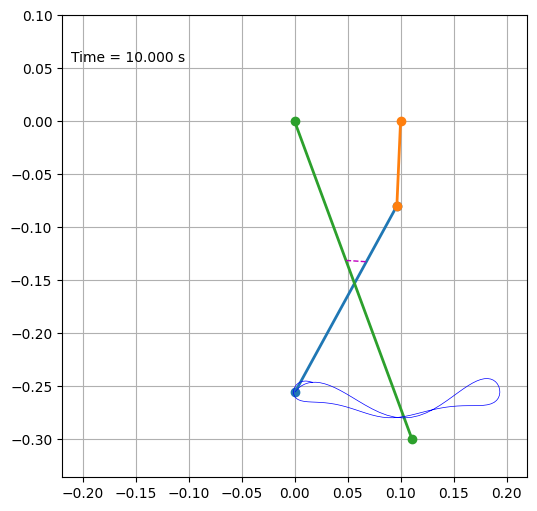

In [25]:
import matplotlib.pyplot as plt
from collections import deque

def animate(F, x0):

    # length of the history trace
    trace_len = 100

    max_y = max(abs(F['data.p2.y']))*1.2
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot(111, autoscale_on=False, xlim=(-max_y, max_y), ylim=(-max_y, 0.1))
    ax.set_aspect('equal', 'datalim')
    ax.grid()

    line1, = ax.plot([], [], 'o-', lw=2)
    line2, = ax.plot([], [], 'o-', lw=2)
    line3, = ax.plot([], [], 'o-', lw=2)
    line4, = ax.plot([], [], 'm--', lw=1)
    trace, = ax.plot([], [], 'b-', lw=0.5, ms=1)
    time_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)
    trace_x, trace_y = deque(maxlen=trace_len), deque(maxlen=trace_len)

    plt.close()
    def init():
        line1.set_data([], [])
        line2.set_data([], [])
        trace.set_data([], [])
        line3.set_data([], [])
        line4.set_data([], [])
        time_text.set_text('')
        trace_x.clear()
        trace_y.clear()
        return line1, line2, trace, time_text

    def animate_frame(i):
        trace_x.appendleft(F['data.p2.x'].iloc[i])
        trace_y.appendleft(F['data.p2.y'].iloc[i])

        line1.set_data([[F['data.p1.x'].iloc[i],F['data.p2.x'].iloc[i]],[F['data.p1.y'].iloc[i], F['data.p2.y'].iloc[i]]])
        line2.set_data([[x0,F['data.p1.x'].iloc[i]],[0, F['data.p1.y'].iloc[i]]])
        line3.set_data([[0,F['data.p3.x'].iloc[i]],[0, F['data.p3.y'].iloc[i]]])
        line4.set_data([[F['data.spr.x0'].iloc[i],F['data.spr.x1'].iloc[i]],[F['data.spr.y0'].iloc[i], F['data.spr.y1'].iloc[i]]])
        trace.set_data(trace_x, trace_y)

        time_text.set_text('Time = %.3f s' % F['data.t'].iloc[i])
        return line1, line2, line3, line4, trace, time_text

    for i in range(len(F)):
        animate_frame(i)
        display(fig, clear=True)